In [2]:
!pip install pybbn

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController #Set Pandas options to display more columns

In [4]:
pd.options.display.max_columns=50

In [5]:
df=pd.read_csv('weatherAUS.csv', encoding='utf-8')

In [6]:
df=df[pd.isnull(df['RainTomorrow'])==False]

In [7]:
df=df.fillna(df.mean())

C:\Users\priya\AppData\Local\Temp/ipykernel_6472/3358723971.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df=df.fillna(df.mean())


In [9]:
df['WindGustSpeedCat']=df['WindGustSpeed'].apply(lambda x: '0.<=40' if x<=40 else
                                                  '1.40-50'  if 40<x<=50 else '2.>50')

In [10]:
df=df.fillna(df.mean())

C:\Users\priya\AppData\Local\Temp/ipykernel_6472/3358723971.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df=df.fillna(df.mean())


In [11]:
df['WindGustSpeedCat']=df['WindGustSpeed'].apply(lambda x: '0.<=40' if x<=40 else 
                                                   '1.40-50'  if 40<x<=50 else '2.>50')

In [12]:
df['Humidity9amCat' ]=df[ 'Humidity9am'].apply(lambda x: '1.>60' if x>60 else '0.<=60')

In [13]:
df['Humidity3pmCat']=df['Humidity3pm'].apply(lambda x: '1.>60' if x>60 else '0.<=60')

In [14]:
print(df)

            Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0     2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1     2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2     2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3     2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4     2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   
...          ...      ...      ...      ...       ...          ...       ...   
1430  2012-11-30   Albury     23.0     34.4       0.0          NaN       NaN   
1431  2013-01-01   Albury     12.1     34.5       0.0          NaN       NaN   
1432  2013-01-02   Albury     13.8     33.6       0.0          NaN       NaN   
1433  2013-01-03   Albury     15.8     36.9       0.0          NaN       NaN   
1434  2013-01-04   Albury     18.6     40.7       0.0          NaN       NaN   

     WindGustDir  WindGustSpeed WindDir

In [15]:
def probs(data, child, parent1=None, parent2=None):
  if parent1==None:
    prob=pd.crosstab(data[child],'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
  elif parent1!=None:
    if parent2==None:
      prob=pd.crosstab(data[parent1],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else:
      prob=pd. crosstab([data[parent1], data[parent2]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
  else: print("Error in Probability Frequency Calculations")
  return prob

In [16]:
H9am = BbnNode(Variable(0, 'H9am', ['<=60', '>60']), probs(df, child='Humidity9amCat'))

In [17]:
H3pm = BbnNode(Variable(1, 'H3pm', ['<=60', '>60']), probs(df, child= 'Humidity3pmCat', parent1='Humidity9amCat'))

In [18]:
W =BbnNode(Variable(2, 'W', ['<=40', '40-50', '>50']), probs(df, child='WindGustSpeedCat'))

In [19]:
RT = BbnNode(Variable(3, 'RT', ['No', 'Yes']), probs(df, child='RainTomorrow', parent1='Humidity3pmCat', parent2='WindGustSpeedCat'))

In [20]:
bbn= Bbn() \
  .add_node(H9am) \
  .add_node(H3pm) \
  .add_node(W) \
  .add_node(RT) \
  .add_edge(Edge(H9am,H3pm, EdgeType.DIRECTED)) \
  .add_edge(Edge(H3pm, RT, EdgeType.DIRECTED)) \
  .add_edge(Edge(W,RT, EdgeType.DIRECTED))

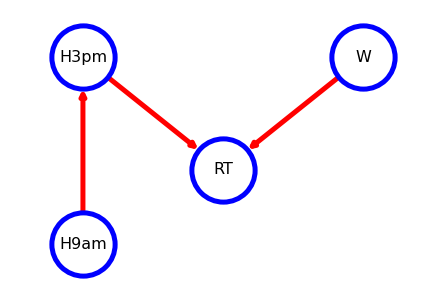

In [21]:
join_tree =InferenceController.apply(bbn)
pos={0: (-1,-2), 1: (-1, 0.5), 2: (1, 0.5), 3:(0,-1)}
options ={
"font_size": 16,
"node_size": 4000,
"node_color": "white",
"edgecolors": "blue",
"edge_color": "red",
"linewidths": 5,
"width": 5,
}
n,d=bbn.to_nx_graph()
nx.draw(n, with_labels=True,labels=d, pos=pos, **options)

ax=plt.gca()
ax.margins (0.20)
plt.axis("off")
plt.show()